In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font
os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [44]:
analysis_year = 2050
scenario_definition = read_csv('Parameter/opcost_sensitivity_analysis.csv', encoding='utf-8')
list_of_sc = scenario_definition['Scenario_ID'].unique()
# scenario_definition.head(5)
print(list_of_sc)

vehicle_type_by_state = read_csv('inputs/fleet/fleet_composition_by_state.csv')
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()
print(list_of_veh_tech)
print(scenario_definition.columns)
scenario_definition_short = \
scenario_definition[['scenario', 'Scenario_ID', 'Diesel_Scenario', 'Elec_Scenario', 'Elec price ($/hWh)']]

scenario_definition_short.head(5)

['High fuel, 0.6 * electricity' 'High fuel, 0.8 * electricity'
 'High fuel, 1.0 * electricity' 'High fuel, 1.2 * electricity'
 'High fuel, 1.4 * electricity' 'Base fuel, 0.6 * electricity'
 'Base fuel, 0.8 * electricity' 'Base fuel, 1.0 * electricity'
 'Base fuel, 1.2 * electricity' 'Base fuel, 1.4 * electricity']
['Diesel Class 4-6 Vocational', 'Electric Class 4-6 Vocational', 'Gasoline Class 4-6 Vocational', 'Diesel Class 7&8 Tractor', 'Electric Class 7&8 Tractor', 'Diesel Class 7&8 Vocational', 'Electric Class 7&8 Vocational']
Index(['scenario', 'Scenario_ID', 'Diesel_Scenario', 'Elec_Scenario',
       'Fuel price ($/gal)', 'Elec price ($/hWh)', 'Elec_FC', 'Diesel_FC',
       'NFC', 'Elec_TC', 'Diesel_TC', 'Rail_TC'],
      dtype='object')


,scenario,Scenario_ID,Diesel_Scenario,Elec_Scenario,Elec price ($/hWh)
0,HOP_highp2,"High fuel, 0.6 * electricity",HOP,p2,0.14
1,HOP_highp4,"High fuel, 0.8 * electricity",HOP,p4,0.19
2,HOP_highp6,"High fuel, 1.0 * electricity",HOP,p6,0.23
3,HOP_highp8,"High fuel, 1.2 * electricity",HOP,p8,0.28
4,HOP_highp10,"High fuel, 1.4 * electricity",HOP,p10,0.33


In [3]:
def get_veh_count(data):
    out_fleet = {}
    out_fleet['BEV Class 4-6 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'Battery Electric', 'Electric Class 4-6 Vocational'].sum()
    out_fleet['BEV Class 7&8 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'Battery Electric', 'Electric Class 7&8 Vocational'].sum()
    out_fleet['BEV Class 7&8 Tractor'] = \
    data.loc[data['EV_powertrain (if any)'] == 'Battery Electric', 'Electric Class 7&8 Tractor'].sum()
    
    out_fleet['PHEV Class 4-6 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'PHEV', 'Electric Class 4-6 Vocational'].sum()
    out_fleet['PHEV Class 7&8 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'PHEV', 'Electric Class 7&8 Vocational'].sum()        
    out_fleet['PHEV Class 7&8 Tractor'] = \
    data.loc[data['EV_powertrain (if any)'] == 'PHEV', 'Electric Class 7&8 Tractor'].sum()
    
    out_fleet['H2FC Class 4-6 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'H2 Fuel Cell', 'Electric Class 4-6 Vocational'].sum()
    out_fleet['H2FC Class 7&8 Vocational'] = \
    data.loc[data['EV_powertrain (if any)'] == 'H2 Fuel Cell', 'Electric Class 7&8 Vocational'].sum()
    out_fleet['H2FC Class 7&8 Tractor'] = \
    data.loc[data['EV_powertrain (if any)'] == 'H2 Fuel Cell', 'Electric Class 7&8 Tractor'].sum()
    
    out_fleet['Diesel Class 4-6 Vocational'] = data.loc[:, 'Diesel Class 4-6 Vocational'].sum() \
    + data.loc[:, 'Gasoline Class 4-6 Vocational'].sum()
    out_fleet['Diesel Class 7&8 Vocational'] = data.loc[:, 'Diesel Class 7&8 Vocational'].sum()
    out_fleet['Diesel Class 7&8 Tractor'] = data.loc[:, 'Diesel Class 7&8 Tractor'].sum()
    out_fleet_df = pd.DataFrame.from_dict(out_fleet, orient='index')
    out_fleet_df = out_fleet_df.reset_index()
    out_fleet_df.columns = ['vehicle type', 'count']
    return(out_fleet_df)
    

In [4]:
out_fleet_mix = None
for sc in list_of_sc:
    print('processing scenario ' + sc)
    input_path = 'outputs_aus_fleet/' + str(analysis_year) + '/' + \
    sc + '/' + 'firms_and_fleet/'
    
#     for sc in list_of_scenarios:
#         print(year, sc)
    firm_file = 'synthetic_firms_with_fleet_mc_adjusted.csv'
    carrier_file = 'synthetic_carriers.csv'
    lease_file = 'synthetic_leasing_company.csv'
    firms_with_fleet = read_csv(input_path + firm_file)
    carriers_with_fleet = read_csv(input_path + carrier_file)
    leasing_with_fleet = read_csv(input_path + lease_file)

    # select Austin only
    aus_zone = [481, 488, 489]
    firms_with_fleet = firms_with_fleet.loc[firms_with_fleet['FAFZONE'].isin(aus_zone)]
    carriers_with_fleet = carriers_with_fleet.loc[carriers_with_fleet['FAFZONE'].isin(aus_zone)]
    leasing_with_fleet = leasing_with_fleet.loc[leasing_with_fleet['FAFZONE'].isin(aus_zone)]
#         firms_with_fleet.head(5)
    firm_fleet_agg = get_veh_count(firms_with_fleet)
    firm_fleet_agg.loc[:, 'source'] = 'firms'
    carrier_fleet_agg = get_veh_count(carriers_with_fleet)
    carrier_fleet_agg.loc[:, 'source'] = 'carrier'
    lease_fleet_agg = get_veh_count(leasing_with_fleet)
    lease_fleet_agg.loc[:, 'source'] = 'lease'

#         firm_fleet_agg = firms_with_fleet.loc[:, list_of_veh_tech].sum()
#         firm_fleet_agg = firm_fleet_agg.to_frame()
#         firm_fleet_agg = firm_fleet_agg.reset_index()
#         firm_fleet_agg.columns = ['vehicle_type', 'total']



#         carrier_fleet_agg = carriers_with_fleet.loc[:, list_of_veh_tech].sum()
#         carrier_fleet_agg = carrier_fleet_agg.to_frame()
#         carrier_fleet_agg = carrier_fleet_agg.reset_index()
#         carrier_fleet_agg.columns = ['vehicle_type', 'total']
#         carrier_fleet_agg.loc[:, 'source'] = 'carrier'

#         lease_fleet_agg = leasing_with_fleet.loc[:, list_of_veh_tech].sum()
#         lease_fleet_agg = lease_fleet_agg.to_frame()
#         lease_fleet_agg = lease_fleet_agg.reset_index()
#         lease_fleet_agg.columns = ['vehicle_type', 'total']
#         lease_fleet_agg.loc[:, 'source'] = 'lease'

    all_fleet_agg = pd.concat([firm_fleet_agg, carrier_fleet_agg, lease_fleet_agg])
#     all_fleet_agg.loc[:, 'year'] = year
    all_fleet_agg.loc[:, 'scenario'] = sc
    out_fleet_mix = pd.concat([out_fleet_mix, all_fleet_agg])
    
#         break
#     break
out_fleet_mix.head(5)
# out_fleet_mix.head(5)

processing scenario HOP_highp2
processing scenario HOP_highp4
processing scenario HOP_highp6
processing scenario HOP_highp8
processing scenario HOP_highp10
processing scenario Ref_highp2
processing scenario Ref_highp4
processing scenario Ref_highp6
processing scenario Ref_highp8
processing scenario Ref_highp10


,vehicle type,count,source,scenario
0,BEV Class 4-6 Vocational,55240.0,firms,HOP_highp2
1,BEV Class 7&8 Vocational,21314.0,firms,HOP_highp2
2,BEV Class 7&8 Tractor,39346.0,firms,HOP_highp2
3,PHEV Class 4-6 Vocational,608.0,firms,HOP_highp2
4,PHEV Class 7&8 Vocational,246.0,firms,HOP_highp2


In [5]:
print(firms_with_fleet.FAFZONE.unique())

[489 488 481]


In [12]:
# generate fleet composition by fraction
# print(out_fleet_mix.vehicle_type.unique())
out_fleet_mix_agg = \
out_fleet_mix.groupby(['vehicle type', 'scenario'])[['count']].sum()
out_fleet_mix_agg = out_fleet_mix_agg.reset_index()
# out_fleet_mix.loc[out_fleet_mix['vehicle typ'] == 'Gasoline Class 4-6 Vocational', 'vehicle_type'] = 'Diesel Class 4-6 Vocational'
# out_fleet_mix_agg.loc[:, 'Case'] = out_fleet_mix_agg.loc[:, 'year'].astype(str) + ' ' + out_fleet_mix_agg.loc[:, 'scenario']
out_fleet_mix_agg.loc[:, 'percentage'] = 100 * out_fleet_mix_agg.loc[:, 'count'] / out_fleet_mix_agg.groupby(['scenario'])['count'].transform('sum')
out_fleet_mix_agg.head(10)

out_fleet_mix_agg.to_csv('outputs_aus_fleet/Aus_fleet_composition_by_scenario.csv')

In [10]:
print(out_fleet_mix_agg['vehicle type'].unique())

['BEV Class 4-6 Vocational' 'BEV Class 7&8 Tractor'
 'BEV Class 7&8 Vocational' 'Diesel Class 4-6 Vocational'
 'Diesel Class 7&8 Tractor' 'Diesel Class 7&8 Vocational'
 'H2FC Class 4-6 Vocational' 'H2FC Class 7&8 Tractor'
 'H2FC Class 7&8 Vocational' 'PHEV Class 4-6 Vocational'
 'PHEV Class 7&8 Tractor' 'PHEV Class 7&8 Vocational']


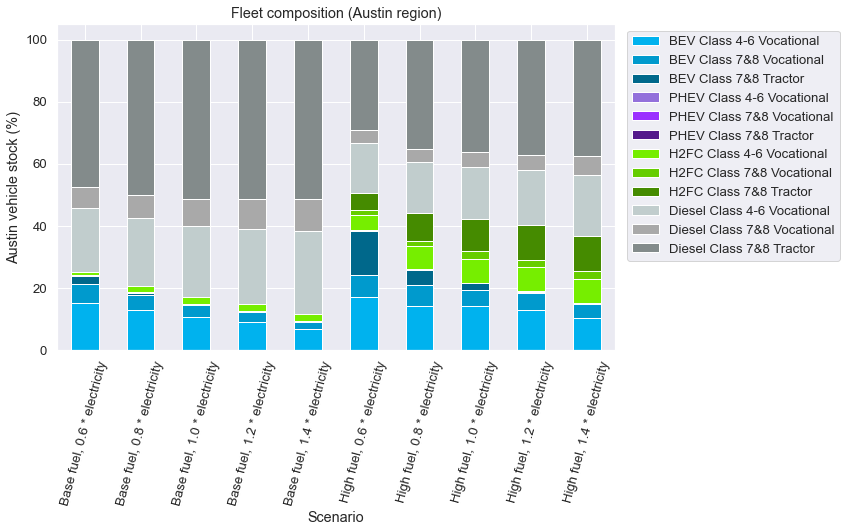

In [50]:
# combined fleet mix plot
combined_fleet_to_plot = \
pd.pivot_table(out_fleet_mix_agg,
               values='percentage', 
               index=['scenario'],
               columns=['vehicle type'], 
               aggfunc=np.sum, sort = False)
combined_fleet_to_plot = combined_fleet_to_plot.reset_index()

combined_fleet_to_plot = combined_fleet_to_plot[['scenario',
                                                 'BEV Class 4-6 Vocational', 
                                                 'BEV Class 7&8 Vocational',
                                                 'BEV Class 7&8 Tractor',
                                                 'PHEV Class 4-6 Vocational', 
                                                 'PHEV Class 7&8 Vocational',  
                                                 'PHEV Class 7&8 Tractor', 
                                                 'H2FC Class 4-6 Vocational', 
                                                 'H2FC Class 7&8 Vocational', 
                                                 'H2FC Class 7&8 Tractor', 
                                                 'Diesel Class 4-6 Vocational', 
                                                 'Diesel Class 7&8 Vocational',
                                                 'Diesel Class 7&8 Tractor']]
colors = ["#00b2ee", "#009acd", "#00688b", # the blues   
          "#9370DB", "#9B30FF", "#551A8B", # the purples
          "#76ee00", "#66cd00", "#458b00", # the greens
          "#c1cdcd", "#a9a9a9", "#838b8b"] # the greys
          
combined_fleet_to_plot = pd.merge(combined_fleet_to_plot,
                                  scenario_definition_short,
                                  on = 'scenario',
                                  how = 'left')
combined_fleet_to_plot = \
combined_fleet_to_plot.sort_values(by = 'Elec price ($/hWh)')

combined_fleet_to_plot = \
    combined_fleet_to_plot.sort_values(by = 'Diesel_Scenario', ascending = False)

combined_fleet_to_plot = \
combined_fleet_to_plot.drop(columns = ['Diesel_Scenario', 'scenario', 'Elec price ($/hWh)'])


combined_fleet_to_plot.plot.bar(x= 'Scenario_ID', 
                                stacked=True, color = colors, figsize = (10, 6))
plt.xticks(rotation = 75)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('Austin vehicle stock (%)')
plt.xlabel('Scenario')
plt.title('Fleet composition (Austin region)')
plt.savefig('outputs_aus_fleet/fleet_composition_austin_SA.png', dpi = 300, bbox_inches = 'tight')

In [40]:
combined_fleet_to_plot.head(5)

,BEV Class 4-6 Vocational,BEV Class 7&8 Vocational,BEV Class 7&8 Tractor,PHEV Class 4-6 Vocational,PHEV Class 7&8 Vocational,PHEV Class 7&8 Tractor,H2FC Class 4-6 Vocational,H2FC Class 7&8 Vocational,H2FC Class 7&8 Tractor,Diesel Class 4-6 Vocational,Diesel Class 7&8 Vocational,Diesel Class 7&8 Tractor,Scenario_ID,Elec_Scenario
0,10.425841,4.339630,0.047279,0.182750,0.076070,0.0,7.869463,2.505160,11.445058,19.470904,6.143187,37.494658,NaN,NaN
1,17.199086,7.039178,14.089546,0.190812,0.078321,0.0,4.948109,1.556433,5.525081,15.984058,4.145247,29.244130,NaN,NaN
2,14.273235,6.663050,4.864413,0.236324,0.084598,0.0,7.345968,1.638023,8.963454,16.475554,4.293986,35.161396,NaN,NaN
3,14.072545,5.204545,2.213363,0.171163,0.103689,0.0,7.589381,2.619451,10.143833,16.792279,4.879551,36.210200,NaN,NaN
4,12.991543,5.297809,0.390626,0.179443,0.104335,0.0,7.681792,2.393725,11.290764,17.530727,5.029745,37.109492,NaN,NaN


,PHEV,H2FC,Diesel,BEV,Scenario_ID
6,0.915921,0.0,52.248062,46.836017,"Base fuel, 0.6 * electricity"
7,0.855178,0.0,59.359588,39.785234,"Base fuel, 0.8 * electricity"
8,1.050303,0.0,68.850745,30.098952,"Base fuel, 1.0 * electricity"
9,0.956914,0.0,74.518460,24.524626,"Base fuel, 1.2 * electricity"
5,0.748205,0.0,81.011948,18.239847,"Base fuel, 1.4 * electricity"


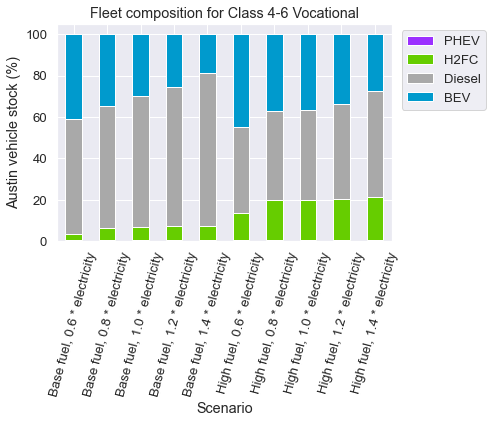

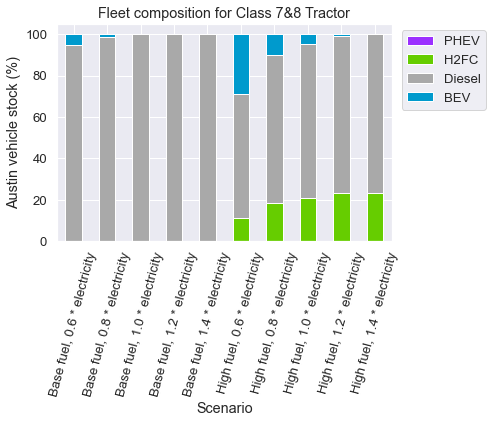

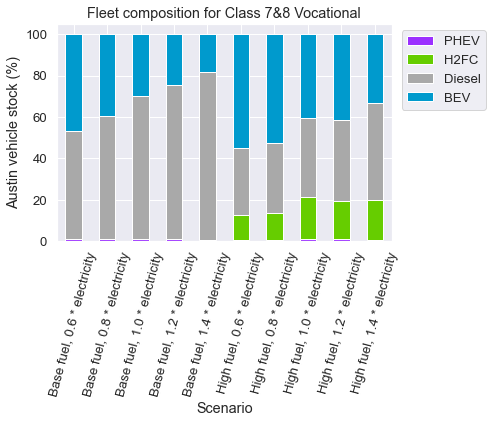

In [51]:
#fleet mix plot by vehicle class
out_fleet_mix_agg.loc[:, 'powertrain'] = out_fleet_mix_agg.loc[:, 'vehicle type'].str.split(' ').str[0]
out_fleet_mix_agg.loc[:, 'body type'] = out_fleet_mix_agg.loc[:, 'vehicle type'].str.split(' ', 1).str[1]
colors_2 = ["#9B30FF", # the purples] 
    "#66cd00",  # the greens
    "#a9a9a9", # the greys
    "#009acd"] # the blues] 

body_types = out_fleet_mix_agg['body type'].unique()
for bt in body_types:
    out_fleet_mix_selected = \
    out_fleet_mix_agg.loc[out_fleet_mix_agg['body type'] == bt]
    out_fleet_mix_selected.loc[:, 'percentage'] = \
    100 * out_fleet_mix_selected.loc[:, 'count'] / \
    out_fleet_mix_selected.groupby(['scenario'])['count'].transform('sum')
    out_fleet_mix_selected = pd.pivot_table(out_fleet_mix_selected,
               values='percentage', 
               index=['scenario'],
               columns=['powertrain'], 
               aggfunc=np.sum, sort = False)
    out_fleet_mix_selected = \
    out_fleet_mix_selected[['PHEV', 'H2FC', 'Diesel', 'BEV']]
    out_fleet_mix_selected = out_fleet_mix_selected.reset_index()

    out_fleet_mix_selected = pd.merge(out_fleet_mix_selected,
                                  scenario_definition_short,
                                  on = 'scenario',
                                  how = 'left')

    out_fleet_mix_selected = \
    out_fleet_mix_selected.sort_values(by = 'Elec price ($/hWh)')
    out_fleet_mix_selected = \
    out_fleet_mix_selected.sort_values(by = 'Diesel_Scenario', ascending = False)

    out_fleet_mix_selected = \
    out_fleet_mix_selected.drop(columns = ['scenario', 'Diesel_Scenario', 
                                           'Elec_Scenario', 'Elec price ($/hWh)'])

    out_fleet_mix_selected.plot.bar(x= 'Scenario_ID', 
                                    stacked=True, color = colors_2)
    plt.xticks(rotation = 75)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.ylabel('Austin vehicle stock (%)')
    plt.xlabel('Scenario')
    plt.title('Fleet composition for ' + bt)
    plt.savefig('outputs_aus_fleet/fleet_composition_' + bt + '_austin_SA.png', dpi = 300, bbox_inches = 'tight')
    
#     break
out_fleet_mix_selected.head(5)

In [43]:
scenario_definition_short.head(5)

,Scenario_ID,Diesel_Scenario,Elec_Scenario,Elec price ($/hWh)
0,"High fuel, 0.6 * electricity",HOP,p2,0.14
1,"High fuel, 0.8 * electricity",HOP,p4,0.19
2,"High fuel, 1.0 * electricity",HOP,p6,0.23
3,"High fuel, 1.2 * electricity",HOP,p8,0.28
4,"High fuel, 1.4 * electricity",HOP,p10,0.33


In [16]:
out_fleet_mix_agg.head(5)

,vehicle type,scenario,count,fraction
0,BEV Class 4-6 Vocational,HOP_highp10,34401.0,0.104258
1,BEV Class 4-6 Vocational,HOP_highp2,56876.0,0.171991
2,BEV Class 4-6 Vocational,HOP_highp4,46566.0,0.142732
3,BEV Class 4-6 Vocational,HOP_highp6,45466.0,0.140725
4,BEV Class 4-6 Vocational,HOP_highp8,41340.0,0.129915
